In [99]:
import logging
import pickle
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from colorama import Fore, Style
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    PowerTransformer,
    MinMaxScaler
)
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import (
    TimeSeriesSplit,
    GridSearchCV
)

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from datetime import datetime, date 

logger = logging.getLogger()
logger.setLevel(logging.ERROR)


In [2]:
df_raw = pd.read_csv('/workspaces/time_series_2/data/raw/Aquifer_Petrignano.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


 
  # Aquifer Petrignano
  

#### A study to predict the groundwater level  
  
Features:  
  
Rainfall indicates the quantity of rain falling (mm)  
Temperature indicates the temperature (°C)  
Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )  
Hydrometry indicates the groundwater level (m)  

Target:
Depth to Groundwater indicates the groundwater level (m from the ground floor)

In [3]:
df_raw.sample(10,random_state=2025)
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [43]:
df_baking = df_raw.copy()

#Depth to Groundwater P24 is for a second aquifer, we only need 1, dropped temp from petrignano because main target is Bastia_Umbra,
# I saw this in multiple sample repos in kaggle
df_baking = df_baking.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

#renaming columns
df_baking.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']


#base targets and features
targets = ['depth_to_groundwater']
features = [feature for feature in df_baking.columns if feature not in targets]

#date time for date column
df_baking['date'] = pd.to_datetime(df_baking['date'], format = '%d/%m/%Y')
df_baking = df_baking.sort_values(by='date')

df_baking.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5223 non-null   datetime64[ns]
 1   rainfall              4199 non-null   float64       
 2   depth_to_groundwater  5184 non-null   float64       
 3   temperature           4199 non-null   float64       
 4   drainage_volume       5025 non-null   float64       
 5   river_hydrometry      4199 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 245.0 KB


## Graph all data in relation to dates

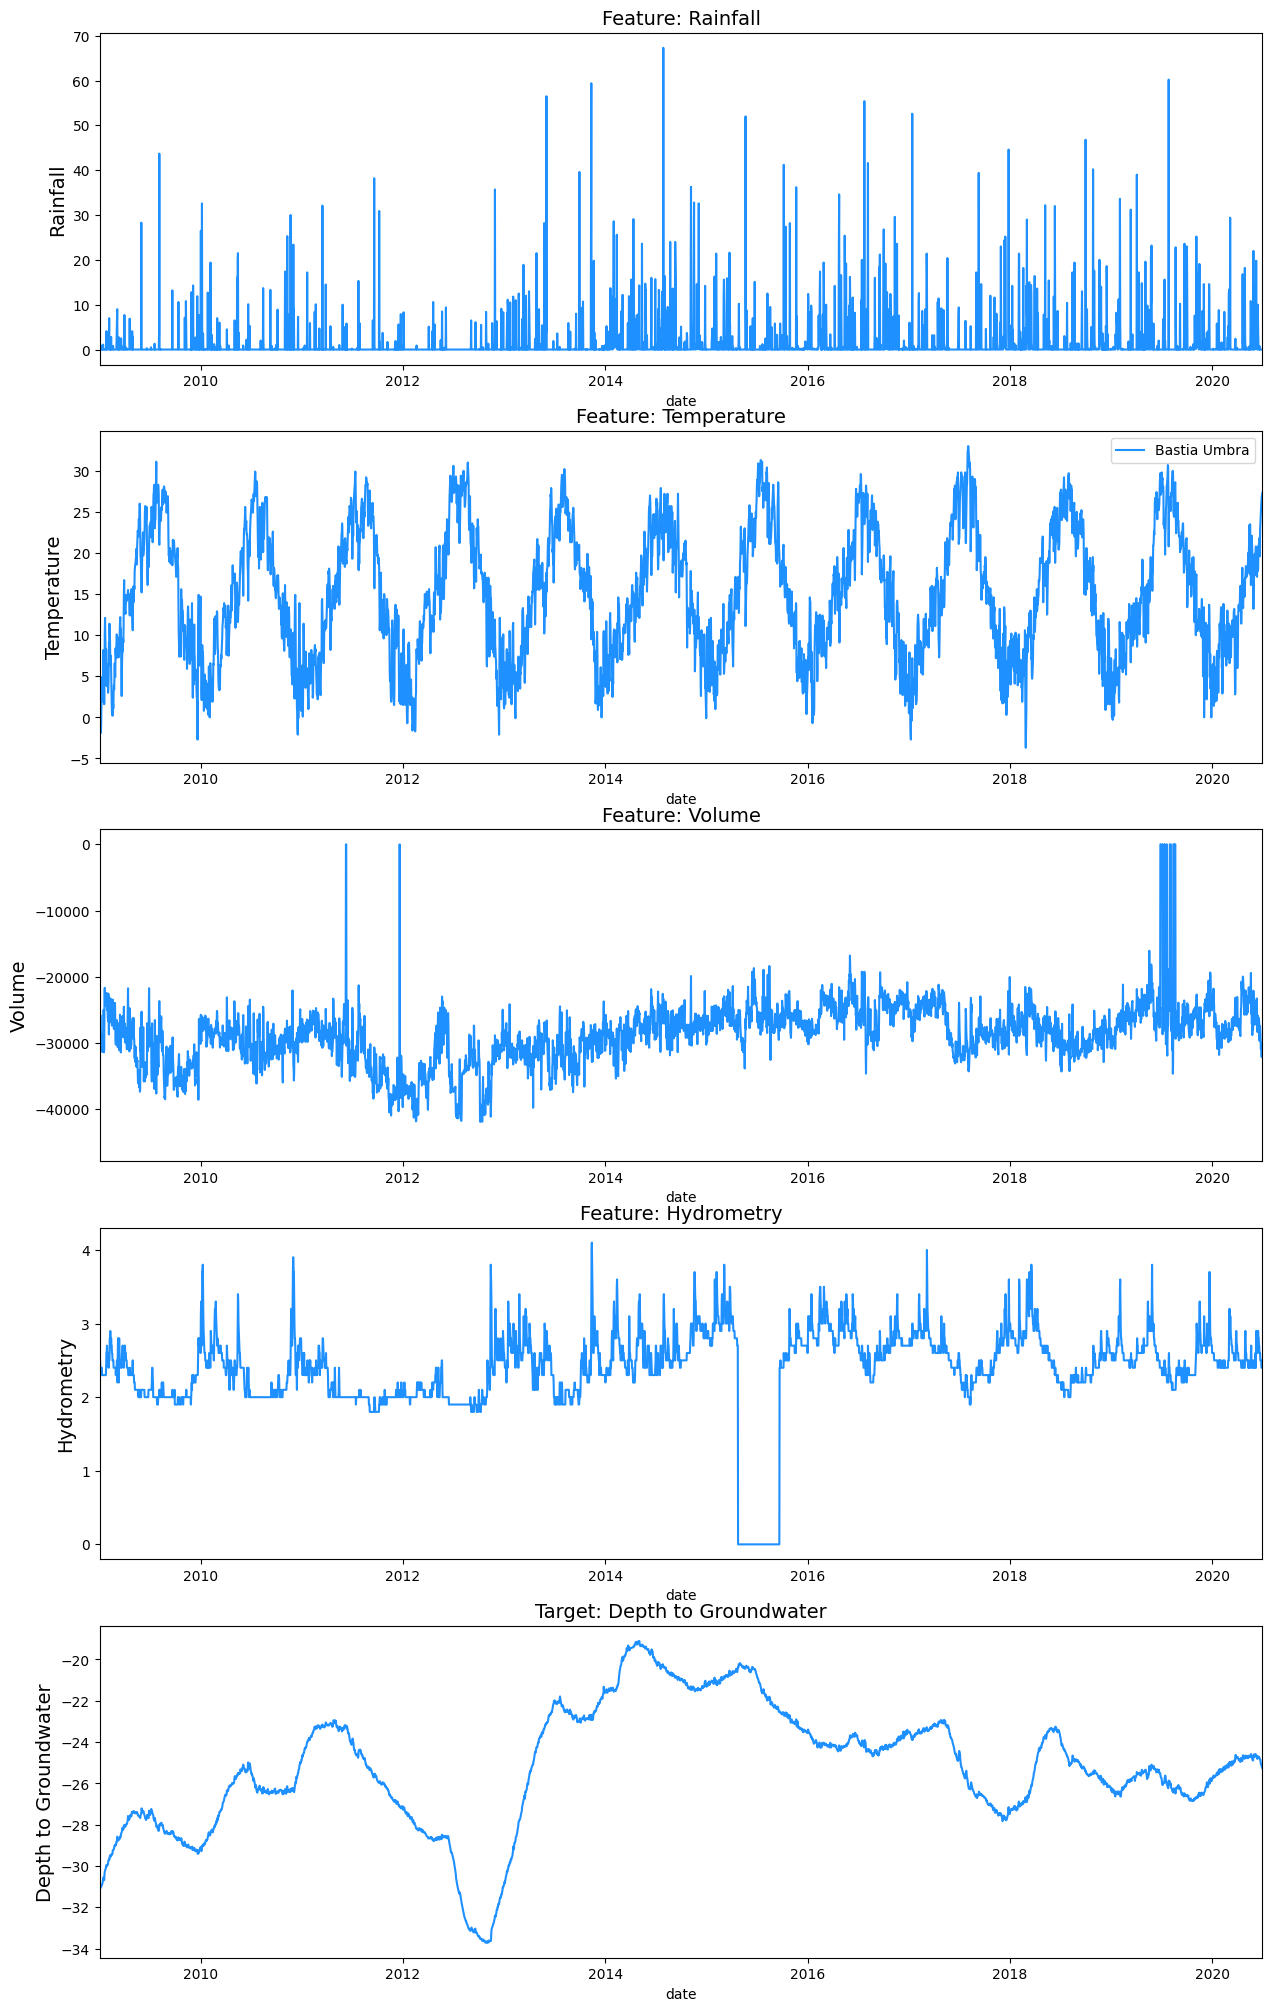

In [29]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df_baking.date, y=df_baking.rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df_baking.date, y=df_baking.temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df_baking.date, y=df_baking.drainage_volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df_baking.date, y=df_baking.river_hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df_baking.date, y=df_baking.depth_to_groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

## Data Preprocessing

#### Handling Missing Values  
  
#####   We are missing values in depth.  
RangeIndex: 5223 entries  
5184 non-null   float64

In [30]:
df_baking['depth_to_groundwater'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5223 entries, 0 to 5222
Series name: depth_to_groundwater
Non-Null Count  Dtype  
--------------  -----  
5184 non-null   float64
dtypes: float64(1)
memory usage: 40.9 KB


##### volume and hydroetry also have 0 values that are not possible
- Volume, there couldn't have been 0 drainage
- hydrometry, rivers don't just stop flowing

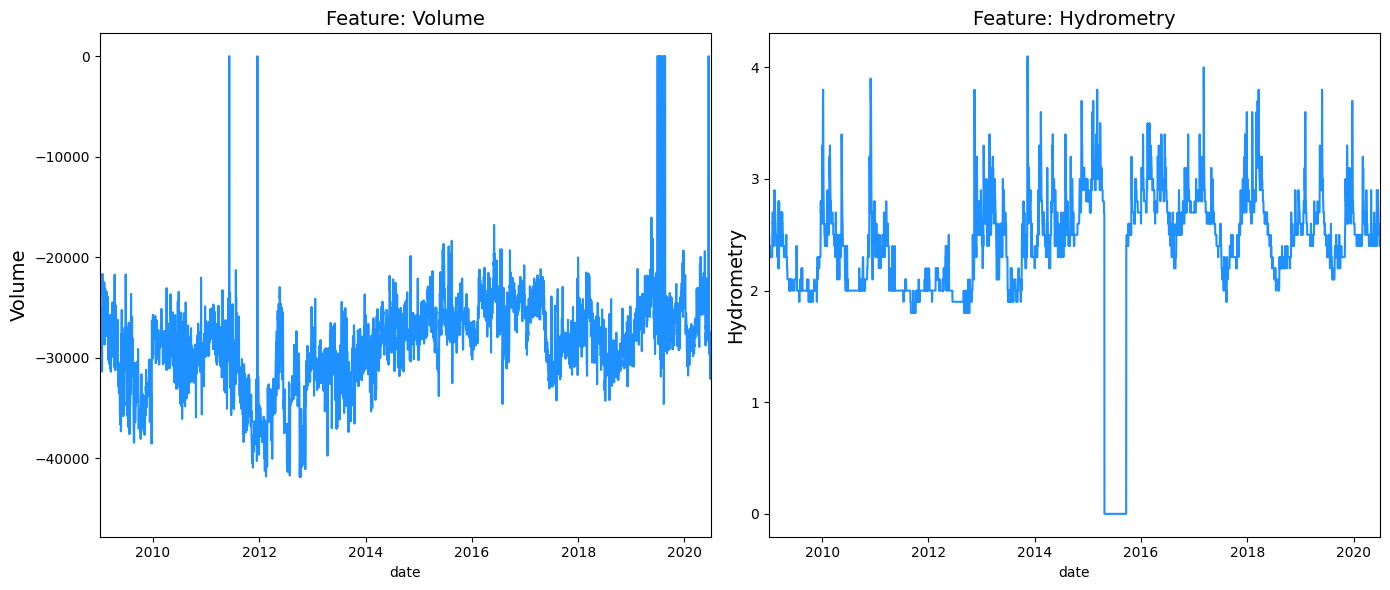

In [32]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))


sns.lineplot(x=df_baking.date, y=df_baking.drainage_volume.fillna(0), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Volume', fontsize=14)
ax[0].set_ylabel('Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df_baking.date, y=df_baking.river_hydrometry.fillna(0), ax=ax[1], color='dodgerblue')
ax[1].set_title('Feature: Hydrometry', fontsize=14)
ax[1].set_ylabel('Hydrometry', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout() 
plt.show()

#### Will interpolate missing values and 0's first

In [60]:

df_baking['drainage_volume'] = df_baking['drainage_volume'].interpolate()
df_baking['river_hydrometry'] = df_baking['river_hydrometry'].interpolate()
df_baking['depth_to_groundwater'] = df_baking['depth_to_groundwater'].interpolate()

### Updated Drainage Volume and Hydrometry

In [61]:
print("\nNull counts AFTER interpolation:")
print(df_baking[['drainage_volume', 'river_hydrometry','depth_to_groundwater' ]].isnull().sum())


Null counts AFTER interpolation:
drainage_volume          197
river_hydrometry        1024
depth_to_groundwater       0
dtype: int64


there are still missing and null values, they are randomly dispersed so I will **Resample** the data using **Downsampling**

In [62]:
# First I am going to replace impossible 0 counts with nulls

invalid_zero_cols = ['drainage_volume', 'river_hydrometry']
df_baking[invalid_zero_cols] = df_baking[invalid_zero_cols].replace(0, np.nan)


def safe_mean(x, min_periods=1):
    """Calculate mean only if minimum non-NaN values exist"""
    return x.mean() if x.count() >= min_periods else np.nan

# 3. Resample with aggregation
df_downsampled = df_baking.resample('7D', on='date').agg({
    'depth_to_groundwater': 'mean',
    'temperature': lambda x: safe_mean(x, min_periods=3),
    'drainage_volume': lambda x: safe_mean(x, min_periods=2),
    'river_hydrometry': lambda x: safe_mean(x, min_periods=2),
    'rainfall': 'sum'
}).reset_index()

# 4. Forward-fill remaining gaps (optional)
df_downsampled = df_downsampled.ffill().bfill()

In [64]:
print("Final zero counts:")
print((df_baking[['date',
                     'depth_to_groundwater', 
                     'temperature',
                     'drainage_volume', 
                     'river_hydrometry']] == 0).sum())

null_count = df_baking['depth_to_groundwater'].isnull().sum()
print(f"Null values in 'depth_to_groundwater': {null_count}")

Final zero counts:
date                    0
depth_to_groundwater    0
temperature             7
drainage_volume         0
river_hydrometry        0
dtype: int64
Null values in 'depth_to_groundwater': 0


Still got some 0's in temp, I am going to check if they are in the winter

In [65]:
zero_temp_indices = df_baking.index[df_baking['temperature'] == 0].tolist()
print("Row indexes with temperature=0:", zero_temp_indices)

target_indexes = [1421, 2159, 2836, 3955, 4679, 5012, 5038]
dates = df_baking.iloc[target_indexes]['date']  # Use .loc if labels are exact

print("Dates for specified rows:")
print(dates)

Row indexes with temperature=0: [1421, 2159, 2836, 3955, 4679, 5012, 5038]
Dates for specified rows:
1421   2010-02-02
2159   2012-02-10
2836   2013-12-18
3955   2017-01-10
4679   2019-01-04
5012   2019-12-03
5038   2019-12-29
Name: date, dtype: datetime64[ns]


##### Temp has possible 0's - so I will keep those

## Stationary

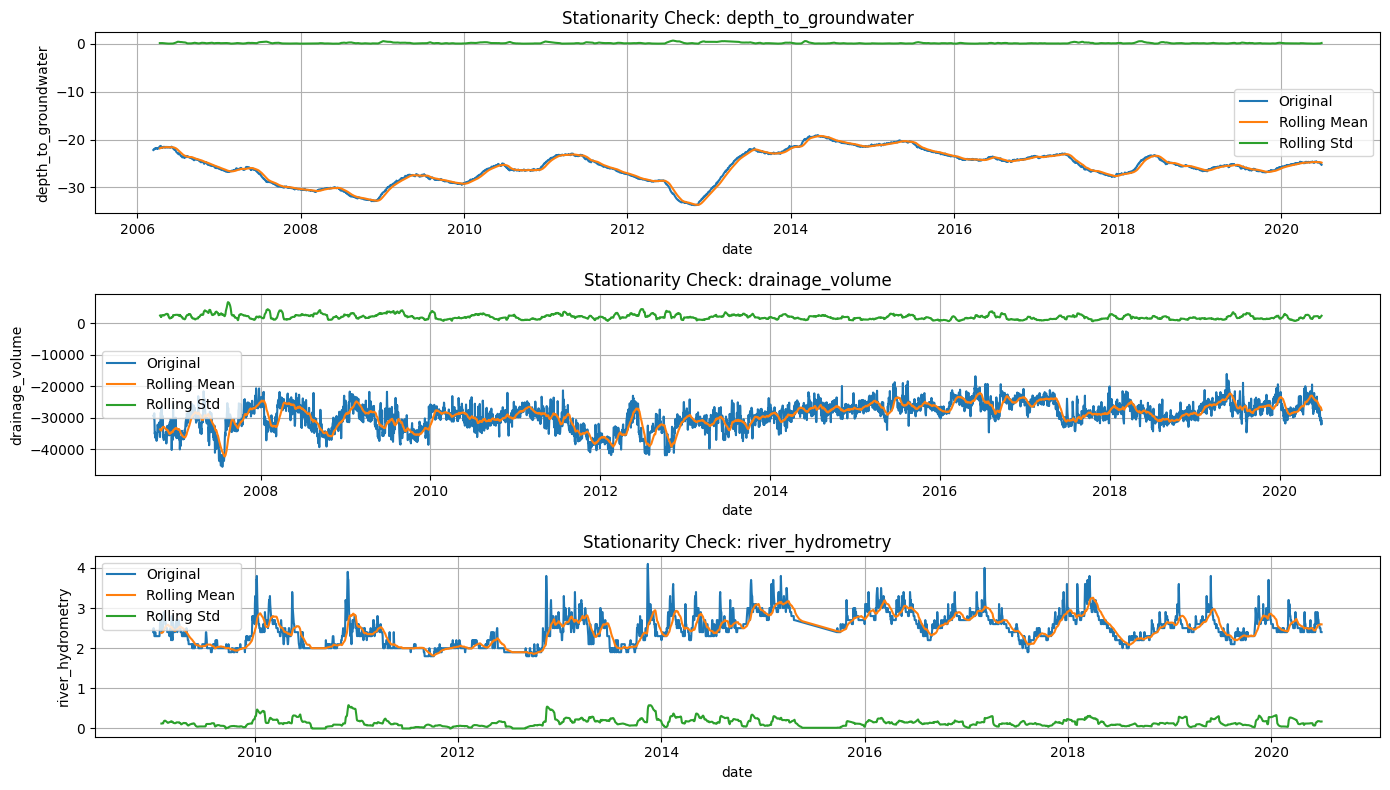

In [66]:
plt.figure(figsize=(14, 8))
target_cols = ['depth_to_groundwater', 'drainage_volume', 'river_hydrometry']

for i, col in enumerate(target_cols, 1):
    plt.subplot(3, 1, i)
    
    # Raw data
    sns.lineplot(data=df_baking, x='date', y=col, label='Original')
    
    # Rolling mean/std (window=30 days)
    df_baking[f'{col}_rolling_mean'] = df_baking[col].rolling(30).mean()
    df_baking[f'{col}_rolling_std'] = df_baking[col].rolling(30).std()
    
    sns.lineplot(data=df_baking, x='date', y=f'{col}_rolling_mean', label='Rolling Mean')
    sns.lineplot(data=df_baking, x='date', y=f'{col}_rolling_std', label='Rolling Std')
    
    plt.title(f'Stationarity Check: {col}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [69]:
result = adfuller(df_baking.depth_to_groundwater.values)
adf_stat = result[0]
p_val = result[1]
crit_val_1 = result[4]['1%']
crit_val_5 = result[4]['5%']
crit_val_10 = result[4]['10%']


print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {p_val:.4f}")


Augmented Dickey-Fuller Test Results:
ADF Statistic: -3.1605
p-value: 0.0224


### ADF Result Confirm Stationary Data

### Time Features

In [78]:

df_baking['date'] = pd.to_datetime(df_baking['date'])

# Extract datetime features
df_baking['year'] = df_baking['date'].dt.year
df_baking['month'] = df_baking['date'].dt.month
df_baking['day'] = df_baking['date'].dt.day
df_baking['day_of_year'] = df_baking['date'].dt.dayofyear
df_baking['week_of_year'] = df_baking['date'].dt.isocalendar().week  # Updated method
df_baking['quarter'] = df_baking['date'].dt.quarter
df_baking['season'] = (df_baking['date'].dt.month % 12) // 3 + 1

# Verification
df_baking[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2006-03-14,2006,3,14,73,11,1,2
1,2006-03-15,2006,3,15,74,11,1,2
2,2006-03-16,2006,3,16,75,11,1,2
3,2006-03-17,2006,3,17,76,11,1,2
4,2006-03-18,2006,3,18,77,11,1,2


In [79]:
df = df_baking.copy()

## Train Test Split

In [82]:
N_SPLITS = 3

X = df.date
y = df.depth_to_groundwater

folds = TimeSeriesSplit(n_splits=N_SPLITS)

df['quarter_idx'] = (df.quarter != df.quarter.shift(1)).cumsum()

target = 'depth_to_groundwater'
features = [feature for feature in df.columns if feature != target]

N_SPLITS = 46

X = df[df.quarter_idx < N_SPLITS][features]
y = df[df.quarter_idx < N_SPLITS][target]

X_test = df[df.quarter_idx == N_SPLITS][features].reset_index(drop=True)
y_test = df[df.quarter_idx == N_SPLITS][target].reset_index(drop=True)

### Naive Approach

𝑦̂ 𝑡+1=𝑦𝑡

In [ ]:
def plot_approach_evaluation(y_pred, score_mae, score_rmse, approach_name):
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    f.suptitle(approach_name, fontsize=16)
    
    # Ensure all data is properly aligned
    plot_dates = X_test['date'].iloc[:len(y_pred)]  # Match dates with predictions
    
    # Plot training data
    sns.lineplot(x=X['date'], y=y, ax=ax[0], color='dodgerblue', 
                 label='Training', linewidth=2)
    
    # Plot ground truth (trim to match prediction length if needed)
    sns.lineplot(x=plot_dates, y=y_test.iloc[:len(y_pred)], ax=ax[0], 
                 color='gold', label='Ground Truth', linewidth=2)
    
    # Plot predictions - KEY FIX: Ensure same length as plot_dates
    sns.lineplot(x=plot_dates, y=y_pred, ax=ax[0], 
                 color='darkorange', label='Predicted', linewidth=2)
    
    # Set plot limits and labels
    ax[0].set_xlim([plot_dates.min(), plot_dates.max()])
    ax[0].set_title(f'Prediction\nMAE: {score_mae[-1]:.2f}, RMSE: {score_rmse[-1]:.2f}', 
                   fontsize=14)
    ax[0].set_xlabel('Date', fontsize=14)
    ax[0].set_ylabel('Depth to groundwater P25', fontsize=14)
    
    # Plot error metrics
    folds = range(1, len(score_mae)+1)
    sns.lineplot(x=folds, y=score_mae, color='gold', label='MAE', ax=ax[1])
    sns.lineplot(x=folds, y=score_rmse, color='indianred', label='RMSE', ax=ax[1])
    ax[1].set_title('Model Error Across Folds', fontsize=14)
    ax[1].set_xlabel('Fold', fontsize=14)
    ax[1].set_ylabel('Error', fontsize=14)
    
    plt.tight_layout()
    plt.show()

# ARIMA

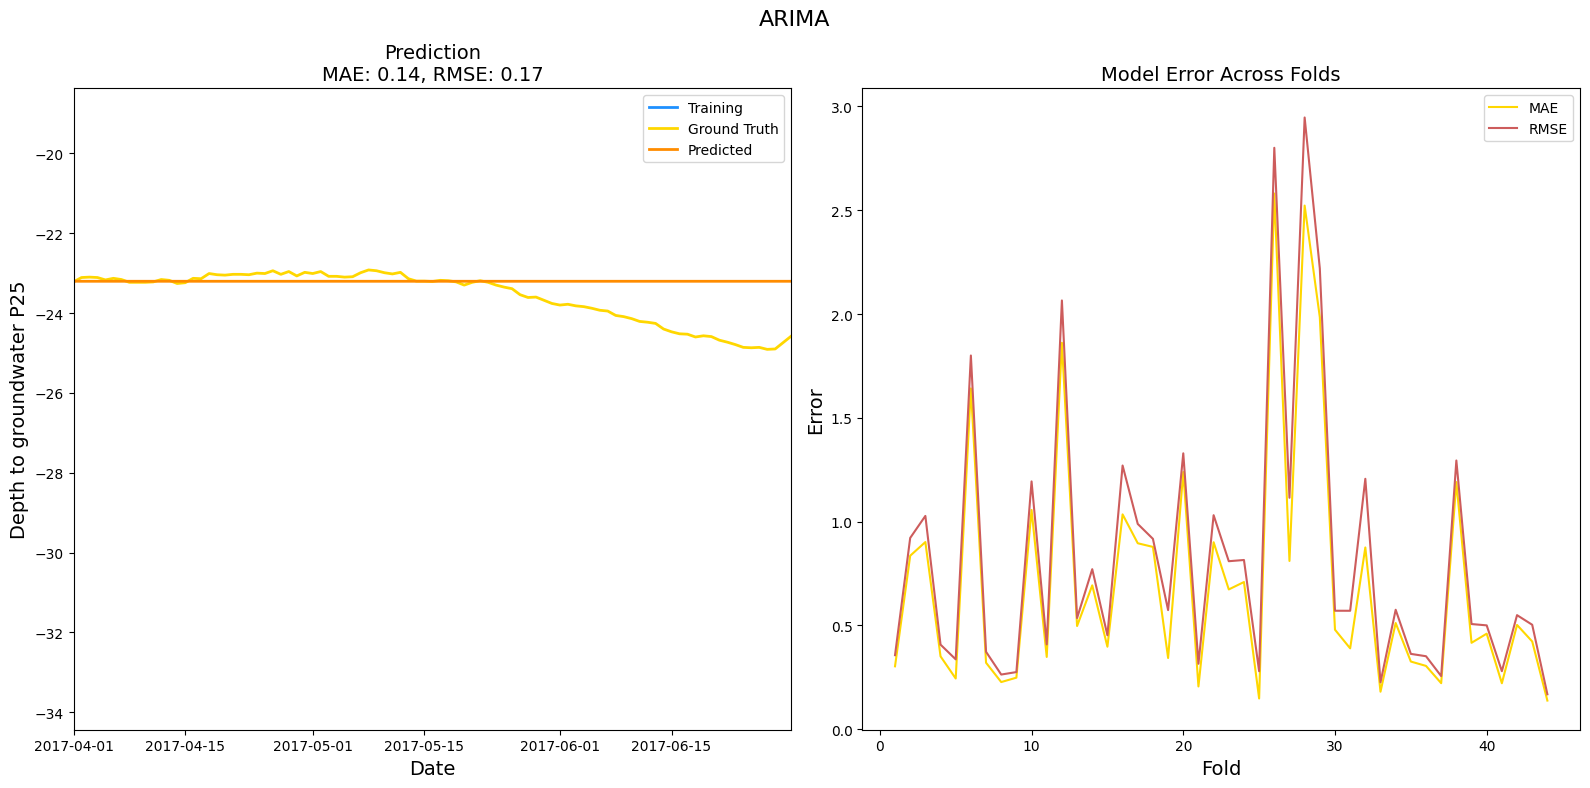

In [105]:
score_mae = []
score_rsme = []

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare training and validation data for this fold
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
    # Fit model with Vector Auto Regression (VAR)
    model = ARIMA(y_train, order=(1,1,1))
    model_fit = model.fit()
    
    # Prediction with Vector Auto Regression (VAR)
    y_valid_pred = model_fit.predict(valid_index[0], valid_index[-1])

    # Calcuate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rsme.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))


# Fit model with Vector Auto Regression (VAR)
model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()

# Prediction with Vector Auto Regression (VAR)
y_pred = model_fit.predict(y.index[-1]+1, y.index[-1] + len(y_test)).reset_index(drop=True)
plot_approach_evaluation(y_pred, score_mae, score_rsme, 'ARIMA')

### ADF Result Confirm Stationary Data

In [96]:
print(model_fit.summary())

                                SARIMAX Results                                 
Dep. Variable:     depth_to_groundwater   No. Observations:                 4036
Model:                   ARIMA(1, 1, 1)   Log Likelihood                5588.614
Date:                  Tue, 06 May 2025   AIC                         -11171.227
Time:                          21:57:24   BIC                         -11152.319
Sample:                               0   HQIC                        -11164.528
                                 - 4036                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1889      0.062     -3.042      0.002      -0.311      -0.067
ma.L1          0.3996      0.060      6.699      0.000       0.283       0.516
sigma2         0.0037   6.26e-05    

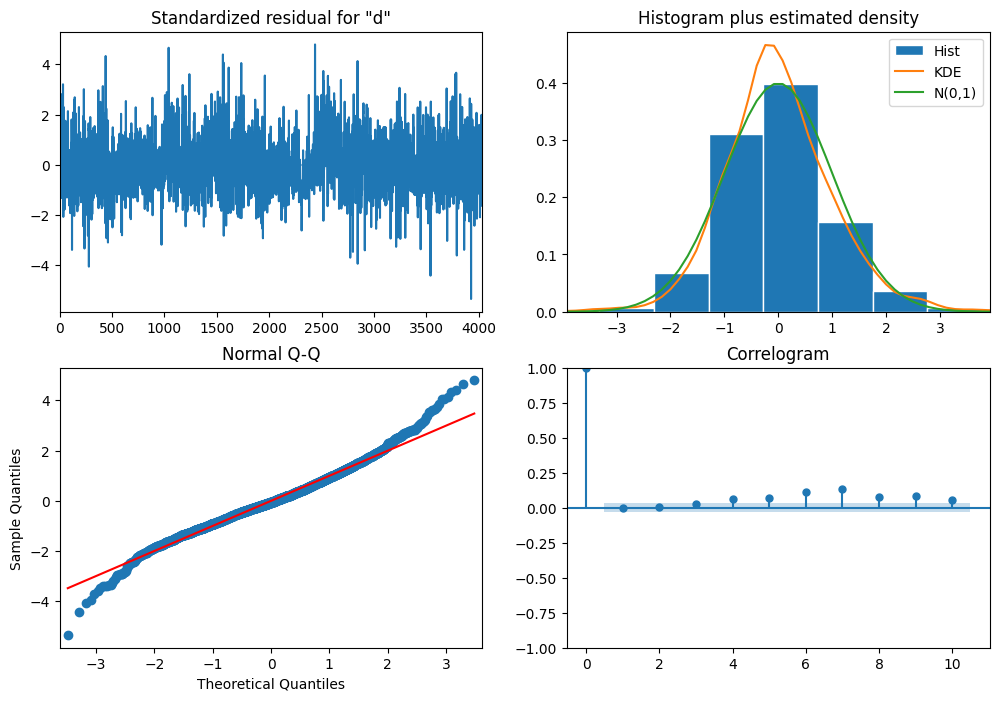

In [98]:
final_model_fit.plot_diagnostics(figsize=(12,8))
plt.show()

## Moving Average

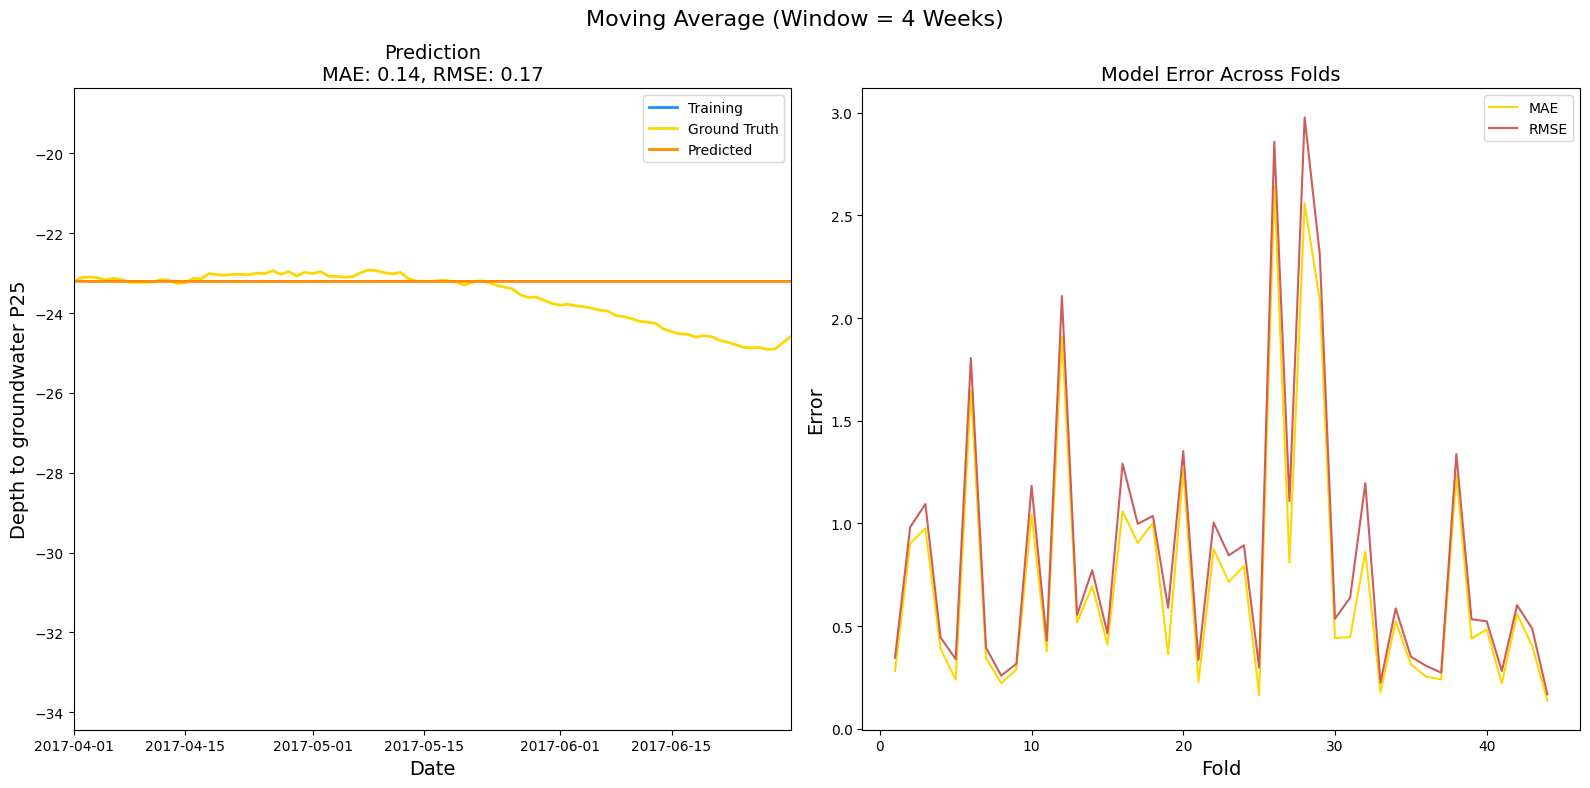

In [107]:
score_mae = []
score_rmse = []  # Fixed typo from rsme to rmse

for fold, valid_quarter_id in enumerate(range(2, N_SPLITS)):
    # Get indices for this fold
    train_index = df[df.quarter_idx < valid_quarter_id].index
    valid_index = df[df.quarter_idx == valid_quarter_id].index

    # Prepare data
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    y_valid_pred = pd.Series(np.nan, index=y_valid.index)  # Initialize with NaN
    
    # Moving average prediction
    for i in range(len(y_valid_pred)):
        # Use pd.concat instead of append
        history = pd.concat([y_train, y_valid_pred.iloc[:i]])
        y_valid_pred.iloc[i] = history.rolling(4).mean().iloc[-1]
        
    # Calculate metrics
    score_mae.append(mean_absolute_error(y_valid, y_valid_pred))
    score_rmse.append(math.sqrt(mean_squared_error(y_valid, y_valid_pred)))

# Test set prediction
y_pred = pd.Series(np.nan, index=X_test.index)
for i in range(len(y_pred)):
    history = pd.concat([y, y_pred.iloc[:i]])
    y_pred.iloc[i] = history.rolling(4).mean().iloc[-1]

plot_approach_evaluation(y_pred, score_mae, score_rmse, 'Moving Average (Window = 4 Weeks)')